In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
BATCH_SIZE = 1

IMG_SIZE = 512

MASK_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

VERSION = '8.2'

# Load data

In [4]:
ABS_PATH = %pwd

In [5]:
slash_idx = [idx for idx,ch in enumerate(ABS_PATH) if ch=='/']

ABS_PATH = ABS_PATH[:slash_idx[-2]]

In [6]:
DATA_DIR = ABS_PATH + '/data/processed'

In [7]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

Parameters of image changed by dataset authors during augmentation:

1. hue  X
2. saturation  X
3. grayscale 
4. contrast  X
5. brightness  X
6. sharpness X
7. adding noise
8. doing flipping  X
9. rotation  X
10. cropping  X
11. padding

In [8]:
@tf.function
def augmentation(input_image, input_mask):
    
    # random crop and resize
    if tf.random.uniform(()) > 0.5:
        
        crop_size = np.random.randint(420, 490, dtype=int)
        
        input_image = tf.image.random_crop(input_image, size=(crop_size, crop_size, 3))
        input_image = tf.image.resize(input_image, [IMG_SIZE, IMG_SIZE])
        
        input_mask = tf.image.resize(input_mask, [IMG_SIZE, IMG_SIZE])
        input_mask = tf.image.random_crop(input_mask, size=(crop_size, crop_size, 1))
        input_mask = tf.image.resize(input_mask, [MASK_SIZE, MASK_SIZE])
        
    # random hue
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_hue(input_image, 0.2)
    
    # random saturation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_saturation(input_image, 5, 10)
    
    # sharpness (image quality decrease)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_jpeg_quality(input_image, 75, 95)
        input_image = tf.reshape(input_image, (IMG_SIZE, IMG_SIZE,3))
        
    # random brightness adjustment illumination
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_brightness(input_image, 0.3)
    
    # random contrast adjustment
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_contrast(input_image, 0.2, 0.5)
    
    # random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    # random vertical flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

#     # rotation in 30° steps
#     if tf.random.uniform(()) > 0.5:
#         rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
#         angle = np.pi/12*rot_factor
#         input_image = tfa.image.rotate(input_image, angle)
#         input_mask = tfa.image.rotate(input_mask, angle)
    
    return input_image, input_mask

In [9]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (MASK_SIZE, MASK_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[MASK_SIZE, MASK_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def load_augmented_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = augmentation(image, mask)
    return image, mask


def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
    """
    Returns augmented or not augmented dataset with the same amount of elements.
    
    Args:
    image_list: list of paths to each image
    mask_list: list of paths to corresponding masks of images (sorted)
    augmentation: "True" for getting augmeneted images and masks
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    if augmentation:
        dataset = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    else:
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    if factor > 1 and augmentation:
        for _ in range(factor-1):
            dataset_to_concat = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
            dataset = dataset.concatenate(dataset_to_concat)

    return dataset

In [10]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))

In [11]:
# opens txt file generated in 6.1 notebook
# txt file contains file paths of low quality masks and
# corresponding images to exclude
# then it removes it from lists of files to be loaded to dataset


def remove_file_paths_according_to_previously_generated_txt(list_with_file_names, nested_list_with_data_paths):

    for name, data_list in zip(list_with_file_names, nested_list_with_data_paths):

        open_path = ABS_PATH + f'/data/evaluation_of_masks/{name}_to_exclude.txt'

        with open(open_path) as file:

            for line in file:
                element = line.rstrip()

                if element in data_list:
                    data_list.remove(element)

                else:
                    pass

In [12]:
file_names = ['train_images', 'train_masks', 'val_images',
            'val_masks']

data_lists = [train_images, train_masks, val_images, 
              val_masks]


remove_file_paths_according_to_previously_generated_txt(file_names, data_lists)

In [13]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))
print("Test Dataset:", test_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(test_dataset))

Train Dataset: <BatchDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7357
Val Dataset: <BatchDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1572
Test Dataset: <BatchDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1602


In [14]:
NUM_TRAIN_IMAGES = BATCH_SIZE * len(train_dataset)
NUM_VAL_IMAGES = BATCH_SIZE * len(val_dataset)

# Class balance 

In [15]:
# class_count = {
#     0: 0.0,
#     1: 0.0,
#     2: 0.0,
#     3: 0.0,
#     4: 0.0
# }

# for mask_path in train_masks:

#     mask = read_image(mask_path, mask=True)
    
#     class_arr = mask[..., 0]

#     one_mask_count = np.unique(class_arr, return_counts=True)

#     for i in range(len(one_mask_count[0])):
#         class_count[one_mask_count[0][i]] += one_mask_count[1][i]

# class_count

,class_number,pixel_count
background,0,1.134440e+09
buildings,1,1.676724e+07
woodland,2,6.487148e+08
water,3,1.265083e+08
roads,4,3.178538e+07


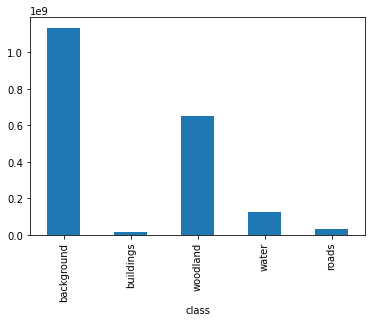

In [16]:
# create dict with already calculated values to bypass renewed calculating

class_count = {
     0: 1134439928.0, 
     1: 16767238.0, 
     2: 648714832.0, 
     3: 126508305.0, 
     4: 31785377.0
}

CLASS_NAMES = ['background', 'buildings', 'woodland', 'water', 'roads']

df = pd.DataFrame(data=class_count.items(), 
                  index=CLASS_NAMES, 
                  columns=['class_number', 'pixel_count'])

df.loc[:, 'pixel_count'].plot.bar()
plt.xlabel('class')

df

In [17]:
def get_class_weight(dictionary):
    
    weights_dict = {}
    
    n_samples = sum(dictionary.values())
    
    for key in dictionary:
        weights_dict[key] = round(n_samples / (NUM_CLASSES * dictionary[key]), 4)
        
    return weights_dict

In [18]:
# def get_class_weight(dictionary):
    
#     id_max_val = max(dictionary, key=dictionary.get)
#     max_val = dictionary[id_max_val]
    
#     for key in dictionary:
#         dictionary[key] = int(max_val / dictionary[key])
        
#     return dictionary

In [19]:
class_weight = get_class_weight(class_count)
class_weight

{0: 0.3452, 1: 23.3576, 2: 0.6037, 3: 3.0958, 4: 12.3215}

# DeepLabv3+

https://keras.io/examples/vision/deeplabv3_plus/

## Create model architecture

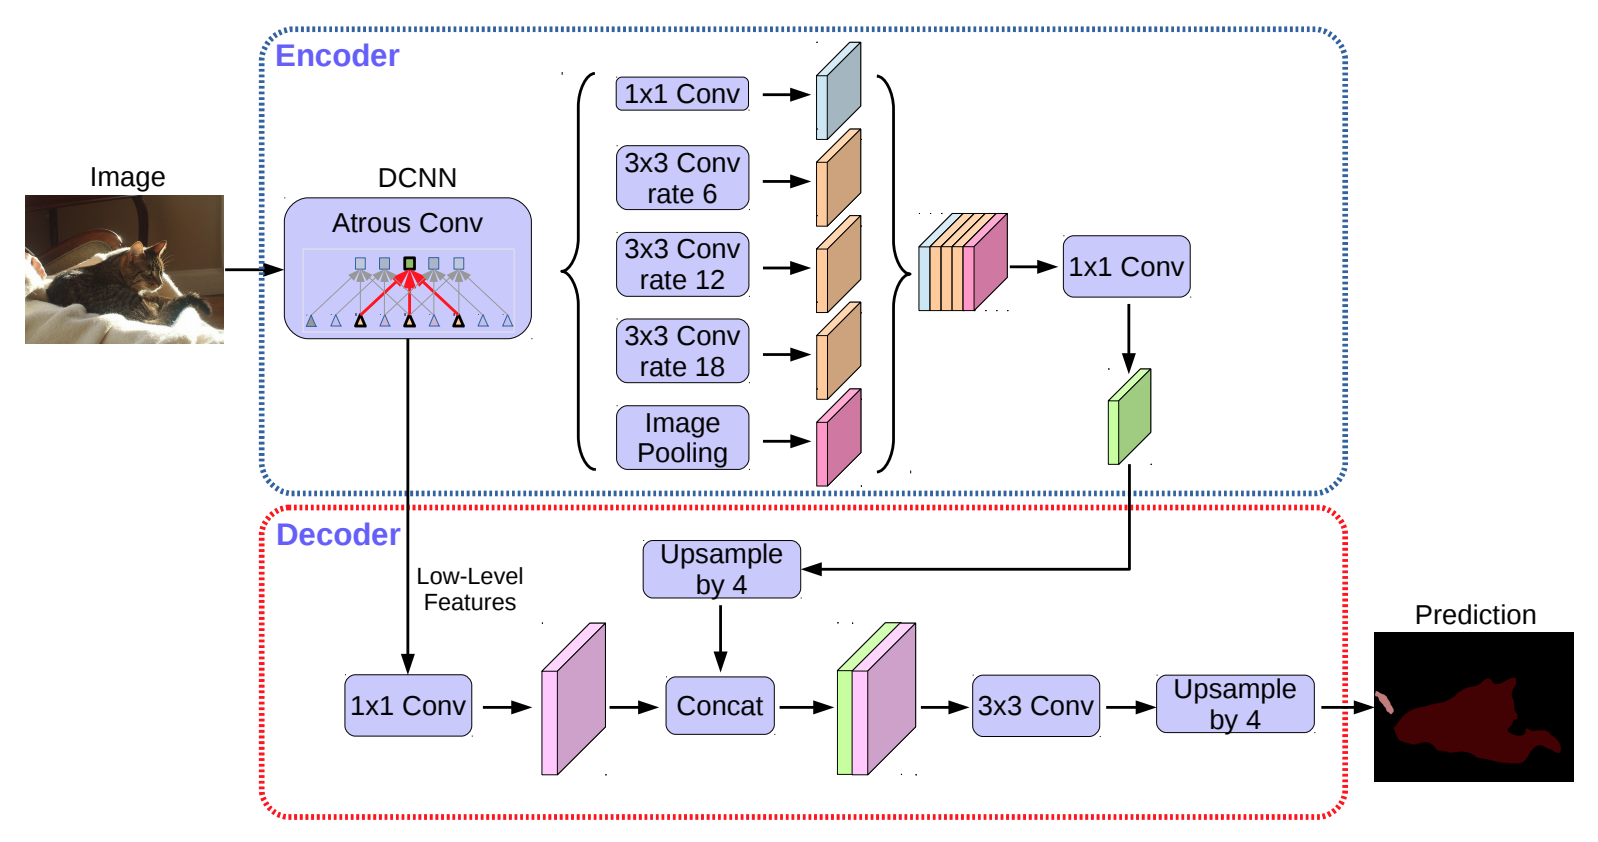

In [20]:
# add additional module import path
import sys 


module_path = ABS_PATH + '/src/models'
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
from modified_deeplabv3plus import Deeplabv3

In [22]:
def get_deeplab_model(weights=None, freeze_conv_base=True, freeze_border=359, activation=None):
    
    """
    Args:
    weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
    freeze_conv_base: True if convolution base should be freezed or 
            False if it to be otherwise
    activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
    
    """
    
    model = Deeplabv3(
        weights=weights,
        classes=NUM_CLASSES,
        backbone='xception',
        OS=16,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        activation=activation)
    
    if freeze_conv_base:
        
        for i, layer in enumerate(model.layers):
            
            if i < freeze_border:
                layer.trainable=False
            else:
                break
                
    return model

## Callbacks

In [23]:
# path_best_miou_weights = ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_class_weights_no_aug/best_miou/checkpoint'
# dir_path_miou = ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_class_weights_no_aug/best_miou'

# for path in [dir_path_miou]:
#     if not os.path.exists(path):
#         os.makedirs(path)

In [24]:
early_stopping_val_mIoU = tf.keras.callbacks.EarlyStopping(monitor='val_mIoU',
                                                           patience=3,
                                                           mode='max')

# best_miou = tf.keras.callbacks.ModelCheckpoint(
#     path_best_miou_weights,
#     monitor='val_mIoU',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='max',
#     save_freq='epoch'
# )

In [25]:
def scheduler(epoch, lr):
    if lr > 0.00001:
        return lr * tf.math.exp(-0.1)
    else:
        return 0.00001


learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Custom MeanIoU metric

In [26]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
                y_true=None,
                y_pred=None,
                num_classes=None,
                name=None,
                dtype=None):
        super(CustomMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [27]:
custom_mIoU_metric = CustomMeanIoU(num_classes=NUM_CLASSES, name='mIoU')

## Loss and loss weights

In [28]:
loss_SCC = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_weights = list(class_weight.values())

loss_weights

[0.3452, 23.3576, 0.6037, 3.0958, 12.3215]

In [29]:
def mask_to_categorical(mask, num_classes):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), num_classes)
    mask = tf.cast(mask, tf.float32)
    return mask

### Boundary loss
https://github.com/LIVIAETS/boundary-loss#requirements-pytorch

In [30]:
from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool_)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [31]:
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import cv2

def distance(label):
    tlabel = label.astype(np.uint8) 
    dist = cv2.distanceTransform(tlabel, 
                                 cv2.DIST_L2, 
                                 0)
    """
    uncomment this if you want to normalize the distance
    """
    dist = cv2.normalize(dist, 
                         dist, 
                         0, 1.0, 
                         cv2.NORM_MINMAX)    
    return dist

def calc_dist_map(seg):
    H,W,C=seg.shape
    res = np.zeros_like(seg)
    for c in range(C):    
        posmask = seg[:,:,c].astype(np.bool_)
        if posmask.any():
            negmask = ~posmask
            res[:,:,c] = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def multiclass_surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

## Evaluation utils

In [32]:
def make_model_history_plots(model_history):
    plt.plot(model_history.history["loss"])
    plt.title("Training Loss (Epoch)")
    plt.ylabel("loss")
    plt.xlabel("Epoch")
    plt.show()

    plt.plot(model_history.history["mIoU"])
    plt.title("Training mIoU (Epoch)")
    plt.ylabel("mIoU")
    plt.xlabel("Epoch")
    plt.show()

    plt.plot(model_history.history["val_loss"])
    plt.title("Validation Loss (Epoch)")
    plt.ylabel("Validation Loss")
    plt.xlabel("Epoch")
    plt.show()

    plt.plot(model_history.history["val_mIoU"])
    plt.title("Validation mIoU (Epoch)")
    plt.ylabel("Validation mIoU")
    plt.xlabel("Epoch")
    plt.show()

In [33]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model):
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], figsize=(18, 14)
        )


In [34]:
colormap = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

### mIOU score for test dataset

In [35]:
def get_miou_for_images(images_list, masks_list, model):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

In [36]:
from tensorflow.keras.metrics import Metric
from typing import Union, List, Tuple

In [37]:
class _IoUBase(Metric):
    """Computes the confusion matrix for Intersection-Over-Union metrics.
    Intersection-Over-Union is a common evaluation metric for semantic image
    segmentation.
    For an individual class, the IoU metric is defined as follows:
    ```
    iou = true_positives / (true_positives + false_positives + false_negatives)
    ```
    From IoUs of individual classes, the MeanIoU can be computed as the mean of
    the individual IoUs.
    To compute IoUs, the predictions are accumulated in a confusion matrix,
    weighted by `sample_weight` and the metric is then calculated from it.
    If `sample_weight` is `None`, weights default to 1.
    Use `sample_weight` of 0 to mask values.
    Args:
    num_classes: The possible number of labels the prediction task can have.
      This value must be provided, since a confusion matrix of size
      `(num_classes, num_classes)` will be allocated.
    name: (Optional) string name of the metric instance.
    dtype: (Optional) data type of the metric result.
    """

    def __init__(self, num_classes, name=None, dtype=None):
        super(_IoUBase, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes

        # Variable to accumulate the predictions in the confusion matrix.
        self.total_cm = self.add_weight(
            'total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer=tf.compat.v1.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """

        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])

        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])

        # Accumulate the prediction to current confusion matrix.
        current_cm = tf.math.confusion_matrix(
            y_true,
            y_pred,
            self.num_classes,
            weights=sample_weight,
            dtype=self._dtype)
        return self.total_cm.assign_add(current_cm)

    def reset_state(self):
        backend.set_value(
            self.total_cm, np.zeros((self.num_classes, self.num_classes)))

In [38]:
class IoU(_IoUBase):
    """Computes the Intersection-Over-Union metric for specific target classes.

    General definition and computation:

    Intersection-Over-Union is a common evaluation metric for semantic image
    segmentation.

    For an individual class, the IoU metric is defined as follows:

    ```
    iou = true_positives / (true_positives + false_positives + false_negatives)
    ```

    To compute IoUs, the predictions are accumulated in a confusion matrix,
    weighted by `sample_weight` and the metric is then calculated from it.

    If `sample_weight` is `None`, weights default to 1.
    Use `sample_weight` of 0 to mask values.

    Note, this class first computes IoUs for all individual classes, then returns
    the mean of IoUs for the classes that are specified by `target_class_ids`. If
    `target_class_ids` has only one id value, the IoU of that specific class is
    returned.

    Args:
    num_classes: The possible number of labels the prediction task can have.
      A confusion matrix of dimension = [num_classes, num_classes] will be
      allocated to accumulate predictions from which the metric is calculated.
    target_class_ids: A tuple or list of target class ids for which the metric
      is returned. To compute IoU for a specific class, a list (or tuple) of a
      single id value should be provided.
    name: (Optional) string name of the metric instance.
    dtype: (Optional) data type of the metric result.

    Standalone usage:

    >>> # cm = [[1, 1],
    >>> #        [1, 1]]
    >>> # sum_row = [2, 2], sum_col = [2, 2], true_positives = [1, 1]
    >>> # iou = true_positives / (sum_row + sum_col - true_positives))
    >>> # iou = [0.33, 0.33]
    >>> m = tf.keras.metrics.IoU(num_classes=2, target_class_id=[0])
    >>> m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
    >>> m.result().numpy()
    0.33333334

    >>> m.reset_state()
    >>> m.update_state([0, 0, 1, 1], [0, 1, 0, 1],
    ...                sample_weight=[0.3, 0.3, 0.3, 0.1])
    >>> # cm = [[0.3, 0.3],
    >>> #        [0.3, 0.1]]
    >>> # sum_row = [0.6, 0.4], sum_col = [0.6, 0.4], true_positives = [0.3, 0.1]
    >>> # iou = [0.33, 0.14]
    >>> m.result().numpy()
    0.33

    Usage with `compile()` API:

    ```python
    model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_id=[0])])
    ```
    """


    def __init__(
      self,
      num_classes: int,
      target_class_ids: Union[List[int], Tuple[int, ...]],
      name=None,
      dtype=None,
    ):
        super(IoU, self).__init__(
            name=name,
            num_classes=num_classes,
            dtype=dtype,
        )
        if max(target_class_ids) >= num_classes:
            raise ValueError(
                 f'Target class id {max(target_class_ids)} is out of range, which is '
                 f'[{0}, {num_classes}).')
        self.target_class_ids = list(target_class_ids)


    def result(self):
        """Compute the intersection-over-union via the confusion matrix."""
        sum_over_row = tf.cast(
            tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(
            tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(
            tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)


        # sum_over_row + sum_over_col =
        #     2 * true_positives + false_positives + false_negatives.
        denominator = sum_over_row + sum_over_col - true_positives


        # Only keep the target classes
        true_positives = tf.gather(true_positives, self.target_class_ids)
        denominator = tf.gather(denominator, self.target_class_ids)


        # If the denominator is 0, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
            tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype))


        iou = tf.math.divide_no_nan(true_positives, denominator)


        return tf.math.divide_no_nan(
            tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)


    def get_config(self):
        config = {
            'num_classes': self.num_classes,
            'target_class_ids': self.target_class_ids,
        }
        base_config = super(IoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [39]:
def get_new_miou(target_class):
    return IoU(NUM_CLASSES, [target_class])

In [40]:
def get_iou_for_every_class(images_list, masks_list, model, save_dir=None):
    
    iou = []
    
    m_1 = get_new_miou(0) 
    m_2 = get_new_miou(1) 
    m_3 = get_new_miou(2) 
    m_4 = get_new_miou(3)
    m_5 = get_new_miou(4) 

    for image_file, mask_file in zip(images_list, masks_list):

        image_tensor = read_image(image_file)

        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
          
        for m in [m_1, m_2, m_3, m_4, m_5]:
            m.update_state([mask_tensor], [prediction_mask])
            
    for m in [m_1, m_2, m_3, m_4, m_5]:
        iou.append(m.result().numpy())
    
    df = pd.DataFrame(iou,
                      index=[i for i in CLASS_NAMES],
                      columns=['IoU score'])
    if save_dir is not None:
        save_path = save_dir + '/iou_for_every_class.csv'
        df.to_csv(save_path, sep='\t')
        print(f'CSV saved to {save_path}')
    else:
        print('CSV won\'t be saved')

    return df

### Confusion matrix


In [41]:
from pretty_confusion_matrix import pp_matrix

In [42]:
# def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
#     """
#     Returns augmented or not augmented dataset with the same amount of elements.
    
#     Args:
#     image_list: list of paths to each image
#     mask_list: list of paths to corresponding masks of images (sorted)
#     augmentation: "True" for getting augmeneted images and masks
#     """
    
#     dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

#     dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
#     dataset = dataset.batch(1, drop_remainder=True)
    
#     return dataset


# test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
# test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))


In [43]:
def get_predictions_and_lables(dataset, predictive_model):

    i = 0
    
    for x, y in dataset:
        
        if i == 0:
            predictions = tf.argmax(predictive_model.predict(x), axis=-1)
            labels = y[..., 0]
     
        elif i > 0:
            mask_pred = tf.argmax(predictive_model.predict(x), axis=-1)
            predictions = tf.concat([predictions, mask_pred], axis=0)
            labels = tf.concat([labels, y[..., 0]], axis=0)

        i += 1
        
    labels = tf.reshape(labels, [labels.shape[0] * labels.shape[1] * labels.shape[2]])
    predictions = tf.reshape(predictions, [predictions.shape[0] * predictions.shape[1] * predictions.shape[2]])

#     matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

#     df_matrix = pd.DataFrame(matrix, index = [i for i in range(NUM_CLASSES)],
#                       columns = [i for i in range(NUM_CLASSES)])

#     pp_matrix(df_matrix, cmap="magma")
    
    return predictions, labels

In [44]:
def get_and_display_confusion_matrix(model, num_classes):
    
    df_matrix = pd.DataFrame(0, index = [i for i in range(num_classes)], 
                             columns = [i for i in range(num_classes)]) 

    step = 6

    for i in range(0, NUM_TEST_IMAGES, step):

        left = int(i)
        right = int(i + step)

        test_dataset = data_generator(test_images[left: right], test_masks[left: right])

        predictions, labels = get_predictions_and_lables(test_dataset, model)

        matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions, num_classes=num_classes).numpy()

        batch_df = pd.DataFrame(matrix, index = [i for i in range(num_classes)],
                          columns = [i for i in range(num_classes)])    

        df_matrix += batch_df

    pp_matrix(df_matrix, cmap="magma")

    return df_matrix

## Train model with dice loss

### Model checkpoint

In [45]:
path_best_dice_loss = ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_no_low_quality_masks/best_miou/checkpoint'
dir_path_dice_loss= ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_no_low_quality_masks/best_miou'

for path in [dir_path_dice_loss]:
    if not os.path.exists(path):
        os.makedirs(path)

In [46]:
best_miou_dice_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

### Soft dice loss

In [47]:
# https://gist.github.com/jeremyjordan/9ea3032a32909f71dd2ab35fe3bacc08#file-soft_dice_loss-py

def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * tf.reduce_sum(y_pred * y_true, axes)
    denominator = tf.reduce_sum(tf.square(y_pred) + tf.square(y_true), axes)
    
    return 1 - tf.reduce_mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

### Model

In [48]:
model = get_deeplab_model(weights='cityscapes', freeze_border=324)

In [49]:
# tf.keras.utils.plot_model(model, to_file='Deeplabv3+.jpg', show_shapes=True)

In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                               best_miou_dice_loss]
                   )


Epoch 1/30
1613/7357 [=====>........................] - ETA: 14:06 - loss: 0.7032 - accuracy: 0.6259 - mIoU: 0.2885

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss (Epoch)")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(history.history["mIoU"])
plt.title("Training mIoU (Epoch)")
plt.ylabel("mIoU")
plt.xlabel("Epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss (Epoch)")
plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(history.history["val_mIoU"])
plt.title("Validation mIoU (Epoch)")
plt.ylabel("Validation mIoU")
plt.xlabel("Epoch")
plt.show()

### Evaluate the model

In [ ]:
model.load_weights(path_best_dice_loss)

In [ ]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range],
                 test_masks[left_range:right_range],
                 colormap,
                 model=model)

In [ ]:
get_miou_for_images(test_images, test_masks, model)

In [ ]:
get_and_display_confusion_matrix(model, NUM_CLASSES)

In [ ]:
every_class_iou = get_iou_for_every_class(test_images, test_masks, model)
every_class_iou

### Decrease learning rate and continue training

In [ ]:
path_best_dice_loss_2 = ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_no_low_quality_masks/best_miou_2/checkpoint'
dir_path_dice_loss_2= ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_no_low_quality_masks/best_miou_2'

for path in [dir_path_dice_loss_2]:
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
best_miou_dice_loss_2 = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss_2,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

In [ ]:
model.load_weights(path_best_dice_loss)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=10e-6),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                              best_miou_dice_loss_2]
                   )


In [ ]:
make_model_history_plots(history)

### Evaluate the model

In [ ]:
model.load_weights(path_best_dice_loss_2)

In [ ]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range],
                 test_masks[left_range:right_range],
                 colormap,
                 model=model)

In [ ]:
get_miou_for_images(test_images, test_masks, model)

In [ ]:
get_and_display_confusion_matrix(model, NUM_CLASSES)

In [ ]:
every_class_iou = get_iou_for_every_class(test_images, test_masks, model, dir_path_dice_loss_2)
every_class_iou

In [ ]:
model.evaluate(test_dataset)

## Decrease lr and continue training

### Model checkpoint

In [ ]:
def get_best_miou_callback_and_path_to_weights(num_string):
    path_best_dice_loss = ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss/best_miou_{num_string}/checkpoint'
    dir_path_dice_loss= ABS_PATH + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss/best_miou_{num_string}'
    
    if os.path.exists(dir_path_dice_loss):
        print("Folder already exists. Change checkpoint number if you don't want to replace previous weights.")
    else:
        os.makedirs(dir_path_dice_loss)

    best_miou_dice_loss= tf.keras.callbacks.ModelCheckpoint(
        path_best_dice_loss,
        monitor='val_mIoU',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
        )
    
    return best_miou_dice_loss, path_best_dice_loss

In [ ]:
best_miou_3, path_best_3 = get_best_miou_callback_and_path_to_weights('3')

In [ ]:
model = get_deeplab_model(freeze_border=244)

In [ ]:
model.load_weights(path_best_dice_loss_2)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=10e-7),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [ ]:
history_3 = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                              best_miou_3]
                   )


In [ ]:
model.evaluate(test_dataset)

In [ ]:
make_model_history_plots(history_3)

# Go back to first saved weights

In [ ]:
model = get_deeplab_model(freeze_border=276)

In [ ]:
model.load_weights(path_best_dice_loss)

In [ ]:
best_miou_4, path_best_4 = get_best_miou_callback_and_path_to_weights('4')

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [ ]:
history_4 = model.fit(train_dataset, 
                     validation_data=val_dataset, 
                     epochs=30,
                     callbacks=[early_stopping_val_mIoU,
                                best_miou_4]
                    )

In [ ]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range],
                 test_masks[left_range:right_range],
                 colormap,
                 model=model)

In [ ]:
get_iou_for_every_class(test_images, test_masks, model)

In [ ]:
model = get_deeplab_model()

In [ ]:
model.load_weights(path_best_4)

In [ ]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range],
                 test_masks[left_range:right_range],
                 colormap,
                 model=model)

In [2]:
get_iou_for_every_class(test_images, test_masks, model)

NameError: name 'get_iou_for_every_class' is not defined

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

model.evaluate(test_dataset)

# Evaluate best model on modified test dataset 

In [ ]:
file_names = ['test_images', 'test_masks']

data_lists = [test_images, test_masks]

remove_file_paths_according_to_previously_generated_txt(file_names, data_lists)

In [ ]:
test_dataset = data_generator(test_images, test_masks)
print("Test Dataset:", test_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(test_dataset))

In [ ]:
model = get_deeplab_model(weights=None)

In [ ]:
model.load_weights(path_best_dice_loss_2)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=10e-6),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [ ]:
model.evaluate(test_dataset)